Content-aware image resizing
===============

I am enrolled in  [School of Economics, Higher Vocational College, Murska
Sobota](http://www.vss-ms.si/), in Information technologies program. Our
program requires for students to complete 10 weeks of internship each year.

This year, I started to look for an internship early on, because I think the
right internship can give you a lot. Needless to say, I was determined.

I had general ideas and priorities about what kind of an internship I want.
I was looking for an internship where I could work on things I was
interested in and with a possibility of later employment.

At the time I was mainly interested in GNU/Linux and, by extension, open-source,
Python, C++ and PostrgeSQL. And, this is important, _no front-end development_! With
repertoire of keywords in my hands, my quest for an internship began. The
location didn't matter as long as it was inside this country (Slovenia).

This led me to [Cyberpipe](http://www.kiberpipa.org/) in Ljubljana, which
is a non-profit organization. I knew there was no chance of employment
here. However, I knew they were working with Linux and Python. 2 out of 4
keywords. Not bad. In addition, they came highly recommended. My request for
internship was accepted. (Thanks!) We sorted the formalities, and I came to
Ljubljana. It was exciting!

My first assignment was to finish a Python tutorial/book [Dive Into Python 3](http://www.diveinto.org/python3/) which I already started back home. This book is described as 'a Python book for the
experienced programmers'. I am _not_ an experienced programmer.

Soon after I finished the book, the mentor mentioned a programming
competition and urged me to sign up. It was organized by a world-class
software company Zemanta and Faculty of Computer and Information Science,
Ljubljana, the students of which the competition was intended for.

I was hesitant. My first encounter with programming was around 3-4 years ago
when I went through a tutorial here and there. Gradually, I came to a
decision I wanted to do something like this as a career. Now in my second
year of school, after only two programming courses, the mentor's suggestion
seemed very daunting. After a few days of his urging and
my consulting with a few other people, I decided to take the plunge and sign up
for the competition. Even though I was still a beginner, I was anxious to
compare wits and knowledge with fellow students from another school. It was
also a chance for me to see where I stand in comparison to my future
competition.

They accepted my application even though I am not a student of that faculty. (Thank
you for the chance!)

Participants could choose from 3 projects/challenges to which we had to find
a solution.

1. Geographic audience segmentation for real-time bidding,
2. Content-aware image resizing,
3. Configuration management.

Read the full [challenge description on Zemanta's blog](http://www.zemanta.com/zemanta-programming-challenge-2015/).

I chose the second challenge, Content-aware image resizing. Why? Two reasons. One, it sounded exciting. And two, against my protests that magic is required to solve this problem, the mentor assured me it is doable. Though in my defense, both, my mentor and I, came to the same conclusion, that it is indeed magic, on multiple occasions from then on.

Problem description
----------------------

I had to write a program that would transform, crop and/or resize an image to arbitrary dimensions without removing the important parts of the original
image. The program consists of two parts, manual and automatic.

In manual mode, the user tells the program what is the important part of the 
input image, what size the output image should be, and the program returns an
output image with important parts intact.
You may think: 'fairly straightforward' and you would be right. Enter the
magic, automatic mode.

In automagic mode, the user does _not_ tell the program what's important.

I have never done image processing as a programmer. Where to start? The
organizers supplied a list of suggested technologies that could help us
tackle this problem.

* PIL, an image processing module for Python, now superseeded by Pillow,
* ImageMagic, a software suite for displaying, converting, and editing images,
* Scikit-learn, the go-to Python library for machine learning,
* Scikit-image, its image-processing counterpart,
* OpenCV, an advanced computer vision programming library by Intel.

They also supplied a list of some existing algorithms for this kind of problem:

* Face and text detection,
* salient feature extraction,
* seam carving.

These libraries and frameworks are not something a total newbie can
get to know in a day or two. After some consultation and research, I decided
to use Pillow and Scikit-image for starters and adopt other packages
if the need arises.

The first step of this project was not image related. The first thing I had
to do was create a command line interface. This was also specified in the
program usage outline from the organizators:

```
./resize --size 320x320 --featured 100x100-150x150 --input /path/to/original/image.png --output output.png

--size        output image size
--featured    coordinates of the important part of the image (optional)
--input       path to the original image
--output      path to the output image
```

Take note of the argument `--featured`. Here is where the user chooses the
manual or the automatic mode. If featured is not given, the program switches
to the automatic mode.

On to some examples.

In [88]:
%matplotlib inline
from autocrop import *
import matplotlib.pyplot as plt
from skimage.filter import scharr

def show(im1, im2):    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 8))
    im1, im2 = ax0.imshow(im1), ax1.imshow(im2)
    ax0.axis('off')
    ax1.axis('off')
    plt.tight_layout()
    plt.show()

The automagic algorithm
--------------------------

Here is how my algorithm, the automagic mode, works in general:

1. Calculate entropy of the input image.
2. Check the entropy values against thresholds. If the values are
    above thresholds, discard the calculation, then blur the original
    image and calculate the entropy again. 
3. Find the center of the window with maximum entropy by convolution with summation kernel of fixed size.
4. Put the pixel in the center and calculate the rectangle of appropriate output size.
5. Readjust the rect to the boundaries of the image.
6. ???
7. Crop.

What is entropy and can it be reversed?

Entropy tells you the amount of information a pixel contains based on its
neighborhood. Entropy plays a central part in my program as it
calculates the relevant part of the image based on it. The bigger the
entropy, the bigger the relevance.

But sometimes an image can contain too much entropy (noise) to give a meaningful
result. When that happens, I blur the image first, because bluring ought to
blur the smaller, less significant features.

Gaussian blur is used to reduce image noise. Entropy calculated on a
blured image which originally contained too much information gives
better results. But blur can also give an opposite result if the mean entropy of the
original image isn't high enough.

Below is an example of an original image and its entropy on the left vs. the blured image and its entropy on the right.

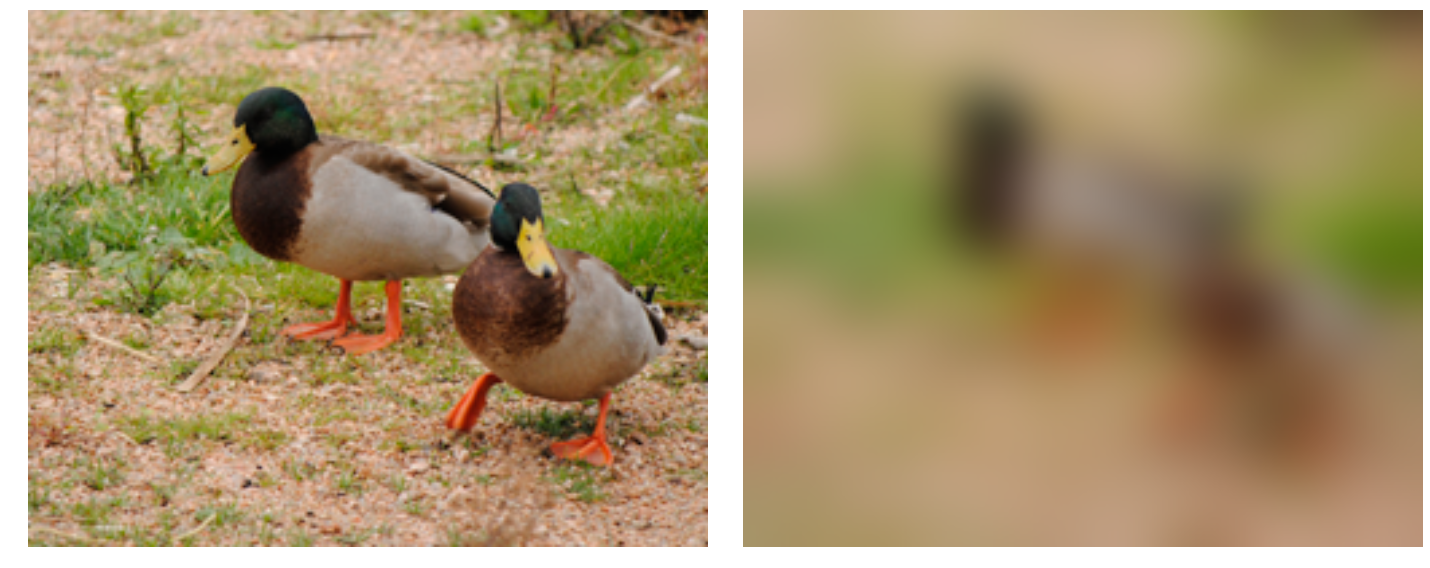

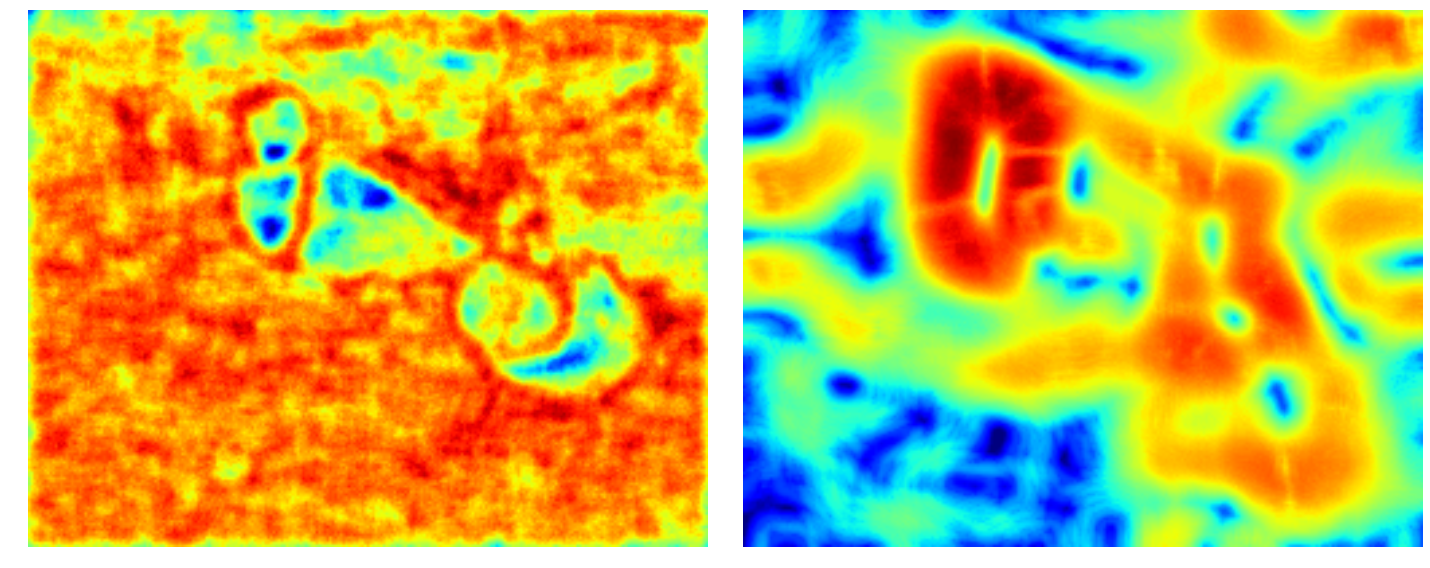

In [89]:
inputfile = './png/15duck.png'
im = Image.open(inputfile)
show(im, blur(im))
H = entropy(np.array(ubyte(grayscale(im))))
B = entropy(np.array(ubyte(grayscale(blur(im)))))
show(H, B)

I use convolution to multiply values of two arrays of same dimensions 
but different sizes. One array is a 2D array of the calculated entropy. 
The second array is a [kernel](http://en.wikipedia.org/wiki/Kernel_%28image_processing%29).
    
Convolution calculates entropy maximum based on a neighborhood and not
just one pixel. Using convolution I can evade imediate local maximums.

Example below.

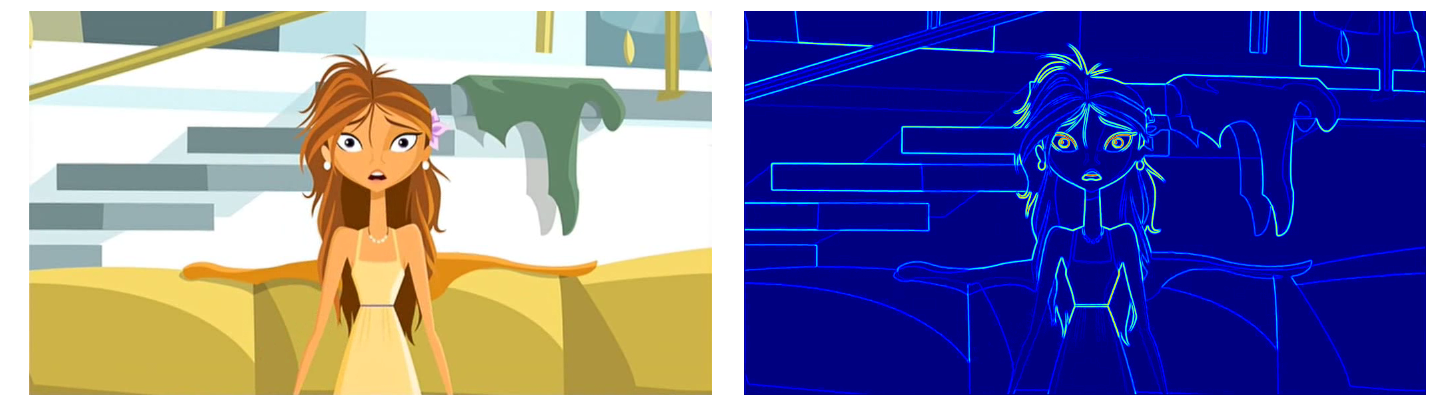

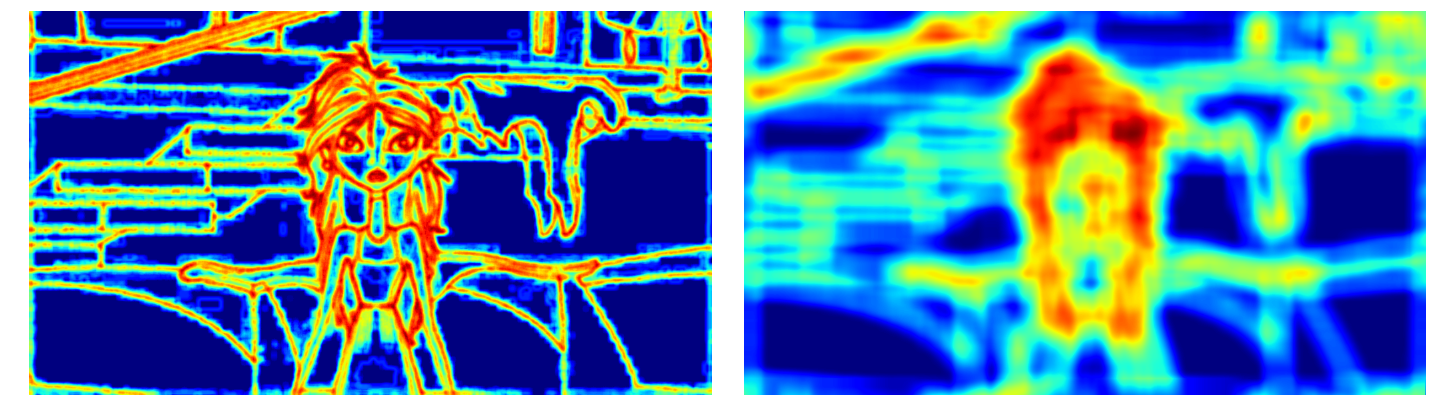

In [90]:
inputfile = './png/04.png'
im = Image.open(inputfile)
show(im, scharr(np.array(ubyte(grayscale(im)))))
H = entropy(np.array(ubyte(grayscale(im))))
HC = convolve(H)
show(H, HC)

So I calculate the position of the pixel that has the highest convoluted
value, center the rectangle around that pixel, and finally readjust it if
the coordinates are outbound of the input image.

Final step is to crop the rectangle and save it to a file.

Similar solutions
-------------------

I found a couple of alternatives that may be worth checking out.

* [ChunkyPNG](https://gist.github.com/zaeleus/a54cd41137b678935c91)
* [Auto Crop ImageJ plugin](http://fiji.sc/Auto_Crop)
* [smarcrop.js](https://github.com/jwagner/smartcrop.js)

These are all open-source solutions, and there are many proprietary ones.

Ideas for the future
-----------------------

I could try implementing seam carving. It is an algorithm for content-aware
scaling. It calculates the seams throughout an image based on an energy
function (e.g. entropy). It can then reduce or enlarge the image by removing or duplicating the seams with optimal energy.

With seam carving implementations, there is a possibility the resulting image will contain deformation artifacts. One workaround is to give the user of the program an option to specify the important and less important parts of an image. 

I could maybe improve the program by implementing a better detection of important features. One idea is to try and see what I could do with a HSV color space instead of RGB for calculating energies. HSV color space seperates color from intensity which can help with better information collection when dealing with shadows or lightning changes in an image.

OpenCV is also an option. It is a computer vision and machine learning 
library and can most probably be used to recognize faces, patches of skin, and identify objects.

I came across [Pyevolve](http://pyevolve.sourceforge.net/), a [genetic algorithm](http://en.wikipedia.org/wiki/Genetic_algorithm)
framework written in Python. I could use it to optimize my
parameter constants which I specified based on my own experimentations.